## Entrega Práctica NLP - Exploración y Visualización - Luis Martín Vegas ##

Cargamos las librerias necesarias.

In [1]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import string
from stop_words import get_stop_words
import string
from google.colab import drive
from nltk import ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.cm as cm

Cargamos los datos:

In [3]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz

--2022-07-03 15:20:50--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45409631 (43M) [application/x-gzip]
Saving to: ‘reviews_Cell_Phones_and_Accessories_5.json.gz’

reviews_Cell_Phones 100%[===================>]  43.31M  12.0MB/s    in 6.2s    

2022-07-03 15:20:57 (7.01 MB/s) - ‘reviews_Cell_Phones_and_Accessories_5.json.gz’ saved [45409631/45409631]



Cargamos los datos a un dataframe y conservamos las columnas de review text y de scores. 

In [4]:
import pandas as pd
df = pd.read_json("reviews_Cell_Phones_and_Accessories_5.json.gz", lines = True, compression = "gzip")
df = df.dropna(subset=["reviewText", "overall"])[["reviewText", "overall"]]
df.head()

,reviewText,overall
0,They look good and stick good! I just don't li...,4
1,These stickers work like the review says they ...,5
2,These are awesome and make my phone look so st...,5
3,Item arrived in great time and was in perfect ...,4
4,"awesome! stays on, and looks great. can be use...",5


Comprobamos cómo se distribuyen las reviews en cuanto a sus scores. Esto es relevante puesto que utilizaremos la variable de puntuación para general una puntuación del sentimiento con la que entrenar y evaluar posteriormente nuestros modelos.

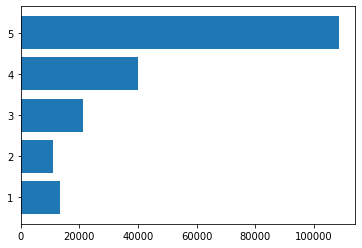

In [5]:
scores = Counter(df.overall)

scores_most_common = scores.most_common(10)
grades = [r[0] for r in scores_most_common]
freqs = [r[1] for r in scores_most_common]

plt.barh(grades, freqs)
plt.show()

Observamos una posible descompensación dado que nuestro dataset contiene en su mayoría reviews positivas. Esto habrá que tenerlo en cuenta a la hora de interpretar los resultados de nuestros modelos y, en caso de verse afectados o influidos por este hecho, habría que porcedes a tratar esta descompensación.

Generamos una variable de sentimiento, a partir de la variable de score. El sentimiento se calificará como positivo (1) o negativo (0).

In [6]:
df.loc[:, "sentiment"] = [0 if rank <= 3 else 1 for rank in df["overall"]]
df.head()

,reviewText,overall,sentiment
0,They look good and stick good! I just don't li...,4,1
1,These stickers work like the review says they ...,5,1
2,These are awesome and make my phone look so st...,5,1
3,Item arrived in great time and was in perfect ...,4,1
4,"awesome! stays on, and looks great. can be use...",5,1


Comprobamos nuevamente la distribución de nuestros datos pero esta vez en relación con el sentimiento asignado.

In [7]:
sentimiento = Counter(df.sentiment)
sentimiento

Counter({0: 45782, 1: 148657})

Nuevamente podemos ver aquí la descompensación de nuestro dataset.

Comenzamos el tratamiento del texto, separándolo por frases en minúsculas.

In [8]:
reviewtext = df.reviewText.str.lower().str.strip().str.split()
reviewtext

0         [they, look, good, and, stick, good!, i, just,...
1         [these, stickers, work, like, the, review, say...
2         [these, are, awesome, and, make, my, phone, lo...
3         [item, arrived, in, great, time, and, was, in,...
4         [awesome!, stays, on,, and, looks, great., can...
                                ...                        
194434    [works, great, just, like, my, original, one.,...
194435    [great, product., great, packaging., high, qua...
194436    [this, is, a, great, cable,, just, as, good, a...
194437    [i, really, like, it, becasue, it, works, well...
194438    [product, as, described,, i, have, wasted, a, ...
Name: reviewText, Length: 194439, dtype: object

Eliminamos carácteres extraños y signos de puntuación que podrían dificultar el la exploración y el análisis que llevaremos a cabo.

In [9]:
table = str.maketrans('', '', string.punctuation)
listapalabras=[]
stop_list = get_stop_words('en')
for sentence in reviewtext:
  for word in sentence:
    if word not in stop_list:
      word2 = word.translate(table)
      if word2 != '':
        listapalabras.append(word2)

Comprobamos cuantas palabras únicas tenemos y cuales son las más frecuentes. Puede ocurrir que algunas, en este contexto deban ser consideradas stopwords adicionales y por tanto suprimidas. Lo evaluamos en este momento.

En total hay 218846 palabras tras quitar las stop_words


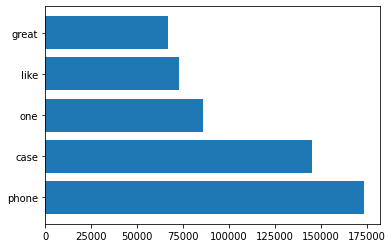

In [10]:
print(f'En total hay {len(Counter(listapalabras))} palabras tras quitar las stop_words')
words_most_common = Counter(listapalabras).most_common(5)
words = [w[0] for w in words_most_common]
freqs = [w[1] for w in words_most_common]
plt.barh(words, freqs)
plt.show()

Analizamos las reviews separándo el texto en bigrams y trigrams.

In [11]:
bigrams_ = list(ngrams(listapalabras, 2))
trigrams_ = list(ngrams(listapalabras, 3))

bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

Comprobamos los más frecuentes:

In [12]:
bg_top = bg_freq.most_common(10)
tg_top = tg_freq.most_common(10)

print("Bigrams Frequencies:")
print("--------------------------------------")
for i in bg_top:
  print(i)

print("\nTrigrams Frequencies:")
print("--------------------------------------")
for i in tg_top:
  print(i)

Bigrams Frequencies:
--------------------------------------
(('screen', 'protector'), 17215)
(('iphone', '5'), 7477)
(('screen', 'protectors'), 6680)
(('works', 'great'), 6642)
(('battery', 'life'), 6391)
(('samsung', 'galaxy'), 6196)
(('phone', 'case'), 6081)
(('works', 'well'), 5245)
(('cell', 'phone'), 4952)
(('sound', 'quality'), 4923)

Trigrams Frequencies:
--------------------------------------
(('samsung', 'galaxy', 's3'), 1076)
(('samsung', 'galaxy', 'note'), 1022)
(('samsung', 'galaxy', 's4'), 999)
(('galaxy', 'note', '2'), 926)
(('micro', 'usb', 'cable'), 851)
(('get', 'pay', 'for'), 825)
(('galaxy', 'note', '3'), 770)
(('fits', 'phone', 'perfectly'), 613)
(('really', 'like', 'case'), 590)
(('highly', 'recommend', 'product'), 579)


Generamos una nube de palabras que nos permita visualizar las más comunes. Para ello definimos una función específca que podamos llamar.

In [13]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

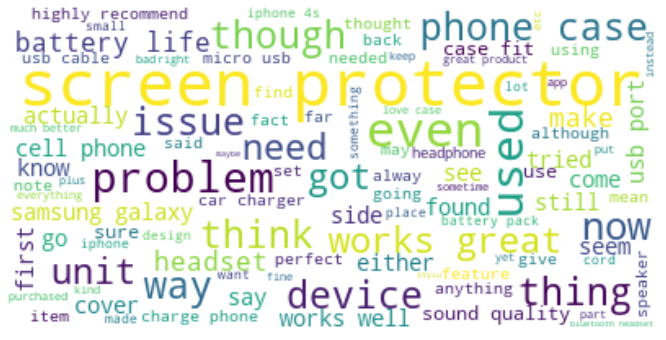

In [14]:
plot_word_cloud(listapalabras)

Podemos comprobar cómo efectivamente las palabras más comunes están altamente relacionadas con el tema en cuestión. Se aprecia también la predominancia de palabras positivas sobre las negativas dado el mayor número de reviews positivas (score > 4). También se hace mucha referencia a nombres específicos de dispositivos y productos. 

A continuación, utilizaremos word2vec para visualizar en 2 dimnensiones los embeddings de un número reducido de obersavaciones para no exceder la capacidad computacional de que disponemos.

In [15]:
w2v_params = {
    'sg': 1,
    'size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}
corpus = df.reviewText.sample(2000)
corpus= corpus.str.split()

In [16]:
w2v_model = Word2Vec(**w2v_params)
w2v_model.build_vocab(corpus)

# Entrenamiento:
w2v_model.train(sentences=corpus, total_examples=w2v_model.corpus_count, epochs=20)

(2293210, 3659400)

In [17]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    plt.show()

In [18]:
keys = ['screen', 'protector', 'device']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [19]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [20]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [21]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


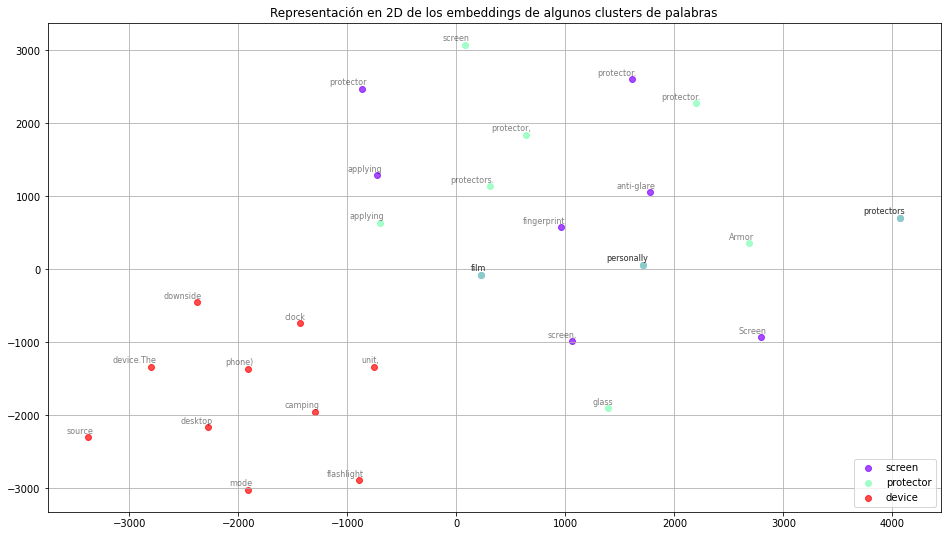

In [22]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)